In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, LogisticRegression, LogisticRegressionCV as Logit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, make_scorer
from sklearn.decomposition import NMF
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
with open('data/fires_df.p', 'rb') as file:
    fires_df = pickle.load(file)

In [2]:
with open('data/target.p', 'rb') as file:
    target = pickle.load(file)

In [3]:
with open('data/predictor.p', 'rb') as file:
    predictor = pickle.load(file)

In [347]:
fires_df = pd.read_csv('data/Fire_Incidents.csv')

C:\Users\pengj\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (11,12,19,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


15_day_hold?
application_number
assessor_stories
avs_street_name
avs_street_sfx
block
city
company_name
contact_name
contact_phone
contractorphone
description
estimated_cost
existing_stories
existing_units
existing_use
expiration_date
file_date
first_name
form_number
last_name
lot
no of pages
plansets
proposed_stories
proposed_units
proposed_use
revised_cost
state
status
status_code
status_date
street
street_number
street_number.1
street_number_sfx
street_suffix
unit
unit_sfx
voluntary soft-story retrofit
zip_code
address

In [349]:
fires_df = fires_df[fires_df['Primary Situation'].apply(lambda x: x[0] == '1')]

In [371]:
x = fires_df['Location'].apply(lambda x: float(x.split(',')[0][1:]))
y = fires_df['Location'].apply(lambda x: float(x.split(',')[1][1:-1]))

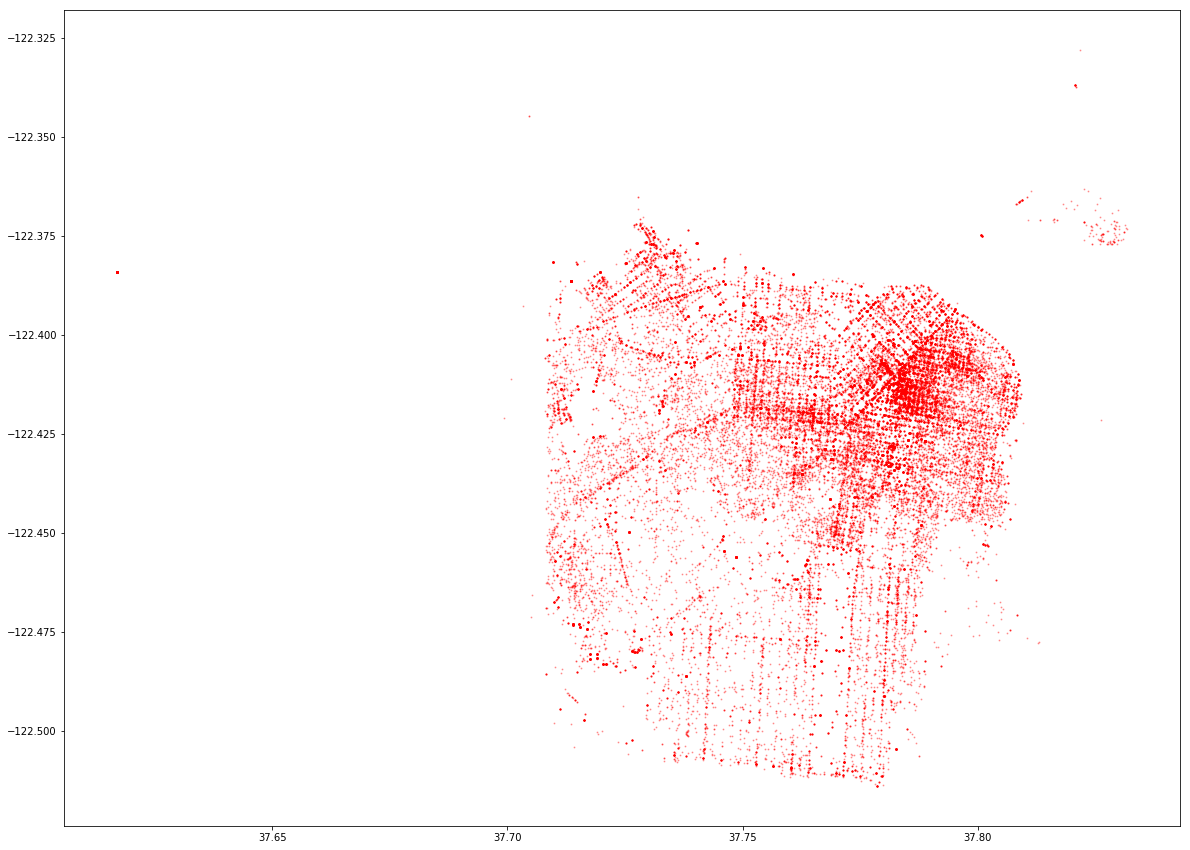

In [379]:
plt.figure(figsize = (20,15))
plt.scatter(x,y, alpha = .3, s = 1, c = 'r')

In [4]:
def data_processing(predictor):
    pred = predictor.copy()
    pred = pred[pred['status'] == 'ISSUED'].reset_index().drop('index', axis = 1)
    return pred

In [5]:
def data_dropping(predictor):
    pred = predictor.copy()
    drop = str.split("application_number first_name form_number last_name lot status_code street street_suffix unit unit_sfx zip_code address street_number street_number.1 street_number_sfx")
    return pred.drop(drop, axis = 1)

In [6]:
pred = data_processing(data_dropping(predictor))

# Testing: just use description

In [8]:
sample_idx = np.random.choice(len(pred), 1000)

In [42]:
sample = pred.iloc[sample_idx]

In [85]:
docs_sample = sample[['description', 'proposed_use', 'existing_use']].fillna('').apply(lambda x: ' '.join(x), axis = 1)

In [47]:
docs_sample = docs_sample.fillna('')

In [71]:
target_sample = target.iloc[sample_idx]

In [13]:
vec = TfidfVectorizer(stop_words = 'english', max_features = 6000)

In [20]:
vec.vocabulary_;

AttributeError: 'TfidfVectorizer' object has no attribute 'vocabulary_'

In [86]:
X = vec.fit_transform(docs_sample).toarray()

In [87]:
X.shape

(1000, 2892)

In [88]:
y = (target_sample['fire_rate'] > 0).astype(int)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [99]:
model = LogisticRegression(penalty = 'l2')
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [100]:
roc_auc_score(y_train, model.predict_proba(X_train)[:,1])

0.9548707445731773

In [101]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) #not a bad start

0.8223795079204583

In [93]:
fpr, tpr, thresh = roc_curve(y_valid, model.predict_proba(X_valid)[:,1])

NameError: name 'y_valid' is not defined

In [466]:
cv_score = cross_val_score(model, X, y, cv = 5, scoring = make_scorer(roc_auc_score))

array([0.60511599, 0.59919833, 0.60086725, 0.60165292, 0.60248738])

In [33]:
cross_val_score(model, X, y, cv = 5, scoring = make_scorer(roc_auc_score))

array([0.63048189, 0.63003767, 0.62145183, 0.62491272, 0.62427039])

In [294]:
y_valid.shape

(1875,)

In [335]:
from sklearn.metrics import explained_variance_score, r2_score

In [336]:
r2_score([1,.5,0], [0,.5,1])

-3.0

# Testing: let's add some numerical features

In [26]:
sample.columns

Index(['15_day_hold?', 'assessor_stories', 'avs_street_name', 'avs_street_sfx',
       'block', 'city', 'company_name', 'contact_name', 'contact_phone',
       'contractorphone', 'description', 'estimated_cost', 'existing_stories',
       'existing_units', 'existing_use', 'expiration_date', 'file_date',
       'no of pages', 'plansets', 'proposed_stories', 'proposed_units',
       'proposed_use', 'revised_cost', 'state', 'status', 'status_date',
       'voluntary soft-story retrofit'],
      dtype='object')

In [104]:
sample['stories_to_add'] = (sample['proposed_stories'] - sample['existing_stories']).fillna(0);

C:\Users\pengj\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [105]:
sample['change_use'] = (sample['existing_use'] == sample['proposed_use']).astype(int)

C:\Users\pengj\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [106]:
numerical_X = sample[['stories_to_add', 'change_use']].values

In [107]:
X_mixed = np.concatenate((numerical_X, X), axis = 1)

In [117]:
train_idx = np.random.choice(range(1000), 750, replace = False)

In [127]:
train_mask = np.full(1000, fill_value = False)
for idx in train_idx:
    train_mask[idx] = True

In [138]:
train = train_mask
test = ~train_mask

In [137]:
numerical_X[train]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [147]:
X[train].shape

(750, 2892)

In [140]:
model.fit(X[train], y[train])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [142]:
roc_auc_score(y[test], model.predict_proba(X[test])[:,1])

0.8577457795431976

In [158]:
X_text = model.predict_proba(X)[:,1]

In [159]:
X_text.shape

(1000,)

In [160]:
X_final = np.concatenate((numerical_X, X_text.reshape(-1,1)),axis = 1)

In [161]:
X_final.shape

(1000, 3)

In [167]:
model_b = LogisticRegression()
model_b.fit(X_final[train], y[train])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [169]:
roc_auc_score(y[test], model_b.predict_proba(X_final[test])[:,1])

0.8534011916583911